In [10]:
!git clone https://github.com/c-bun/NanoBiT-BRET.git

fatal: destination path 'NanoBiT-BRET' already exists and is not an empty directory.


In [11]:
import pandas as pd
#from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import numpy as np
from scipy.optimize import curve_fit
#drive.mount('/content/gdrive')

In [12]:
file_path = '/content/NanoBiT-BRET/BRET efficiencies/QD BRET spectra.xlsx'
df = pd.read_excel(file_path)
df = df.melt(id_vars=['Peptide', 'Wavelength'], var_name='Trial', value_name='Luminescence')

In [13]:
# set the dtype for D5 and Wavel. to int64
df['Luminescence'] = df['Luminescence'].astype('int64')
df['Wavelength'] = df['Wavelength'].astype('int64')

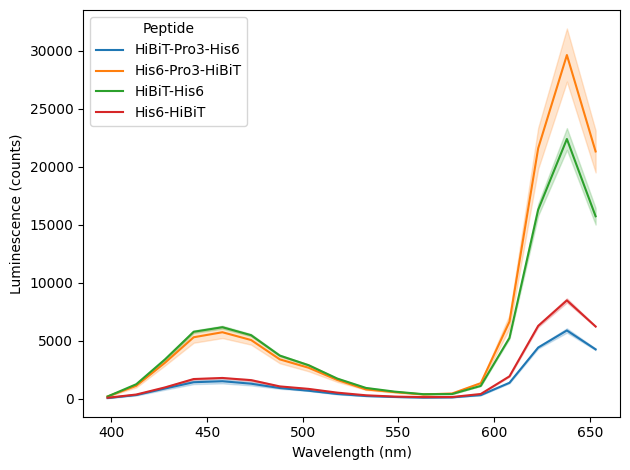

In [14]:
# rename a few columns for publication
df = df.rename(columns={'Wavelength': 'Wavelength (nm)', 'Luminescence': 'Luminescence (counts)'})
df = df.set_index('Peptide')
df = df.rename(index={
    'SmBiT-P3-His6':'HiBiT-Pro3-His6',
    'His6-Pro3-SmBiT':'His6-Pro3-HiBiT',
    'SmBiT-His6':'HiBiT-His6',
    'His6-SmBiT':'His6-HiBiT'
})
df = df.reset_index()
sns.lineplot(data=df, x='Wavelength (nm)', y='Luminescence (counts)', hue='Peptide')
plt.tight_layout()
#plt.savefig('./QD_linker_spectra.pdf')

In [15]:
def extrapolate(df, x_col, y_col, start=-2, stop=None):
  df[y_col] = df[y_col].astype('float64')
  df[x_col] = df[x_col].astype('float64')

  # extrapolate the final point
  y = df[y_col][start:stop].values
  x = df[x_col][start:stop].values
  print(x,y)
  m, b = np.polyfit(x, y, 1)

  # find the x intercept
  x_intercept = -b/m
  extrap_y = m*x_intercept + b

  x = np.append(df[x_col].values, x_intercept)
  y = np.append(df[y_col].values, extrap_y)

  return x, y

def trapezoidal_int(x, y, cutoff):
  all = integrate.trapezoid(y, x)
  lgbit = integrate.trapezoid(y[:cutoff], x[:cutoff])
  bret = integrate.trapezoid(y[cutoff:], x[cutoff:])
  efficiency = bret/all
  print("Total: ",all)
  print("LG-bit: ",lgbit)
  print("BRET: ",bret)
  print("Efficiency: ",efficiency)
  return all, lgbit, bret, efficiency

def gaussian(x, a, emission_max, width):
    return a * np.exp(-((x - emission_max)**2) / (2 * width**2))

def boltzmann(w, w_plus, w_minus, w_max, I_max):
  # from https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1751-1097.1996.tb02464.x
  # this does not currently work.
  v = 1/w
  v_plus = 1/w_plus
  v_minus = 1/w_minus
  v_max = 1/w_max
  H = v_plus - v_minus
  rho = (v_max - v_minus)/(v_plus - v_max)
  a = v_max + H*rho/(rho**2 - 1)
  I = I_max * np.exp(-(np.log(2)/np.log(rho)**2) * np.log((a - v)/(a - v_max))**2)
  # still need to implement. some of the math symbols are weird
  # if v < a:
  #   return I
  # else:
  #   return 0
  return np.where(v < a, I, 0)

def extrapolate_gaussian(df, x_col, y_col, cutoff, function=gaussian):
  # Drop rows with NaN in the y_col before converting to numpy arrays
  df = df.dropna(subset=[y_col]).copy()

  y_col = df[y_col].astype('float64').values
  x_col = df[x_col].astype('float64').values
  cutoff = list(x_col).index(cutoff)

  # fit to gaussian
  print("Fitting x,y: ",x_col[cutoff:], y_col[cutoff:])
  popt, pcov = curve_fit(function, x_col[cutoff:], y_col[cutoff:],
                         p0=[20000, 400, 50], # for gaussian
                         bounds=([1000, 100, 1], [100000, 1000, 500]), # for gaussian
                         #p0=[10, 10, 550, 1], # for boltzmann
                         #bounds=([1, 1, 1, 0.1], [100, 100, 1000, 1]), # for boltzmann
                         )
  #a, emission_max, width = popt
  print("Found params: ", popt)

  # add 20 more datapoints (100 nm worth)
  x_extrap = np.linspace(x_col[-1]+5, x_col[-1]+105, 20)
  y_extrap = function(x_extrap, *popt)

  x = np.append(x_col, x_extrap)
  y = np.append(y_col, y_extrap)

  return x, y, popt

HiBiT-Pro3-His6 Trial 1
Fitting x,y:  [563. 578. 593. 608. 623. 638. 653.] [  87.  114.  321. 1409. 4493. 6067. 4180.]
Found params:  [6133.9574838   637.40709689   17.64193564]
Total:  398072.9914310839
LG-bit:  133125.0
BRET:  251972.99143108388
Efficiency:  0.6329818823558808
HiBiT-Pro3-His6 Trial 2
Fitting x,y:  [563. 578. 593. 608. 623. 638. 653.] [  80.   95.  275. 1317. 4315. 5689. 4315.]
Found params:  [5828.63473753  638.36427917   18.42824152]
Total:  371051.89638339623
LG-bit:  108735.0
BRET:  250376.89638339632
Efficiency:  0.6747759513528797
His6-Pro3-HiBiT Trial 1
Fitting x,y:  [563. 578. 593. 608. 623. 638. 653.] [  383.   472.  1423.  7215. 23364. 31936. 23134.]
Found params:  [3.23897344e+04 6.38104893e+02 1.79142825e+01]
Total:  1923653.0812359243
LG-bit:  503715.0
BRET:  1355153.081235924
Efficiency:  0.704468541887633
His6-Pro3-HiBiT Trial 2
Fitting x,y:  [563. 578. 593. 608. 623. 638. 653.] [  328.   405.  1234.  6053. 19832. 27354. 19514.]
Found params:  [2.768403

,Peptide,Trial,Total,LG-bit,BRET,Efficiency,Medintz Ratio
0,HiBiT-Pro3-His6,Trial 1,3.980730e+05,133125.0,2.519730e+05,0.632982,1.892755
1,HiBiT-Pro3-His6,Trial 2,3.710519e+05,108735.0,2.503769e+05,0.674776,2.302634
2,His6-Pro3-HiBiT,Trial 1,1.923653e+06,503715.0,1.355153e+06,0.704469,2.690317
3,His6-Pro3-HiBiT,Trial 2,1.621700e+06,420435.0,1.146612e+06,0.707043,2.727204
4,HiBiT-His6,Trial 1,1.434809e+06,487927.5,9.001036e+05,0.627334,1.844749
5,HiBiT-His6,Trial 2,1.531404e+06,509580.0,9.735843e+05,0.635746,1.910562
6,His6-HiBiT,Trial 1,5.344531e+05,150187.5,3.669331e+05,0.686558,2.443166
7,His6-HiBiT,Trial 2,5.182748e+05,141127.5,3.597773e+05,0.694182,2.549307


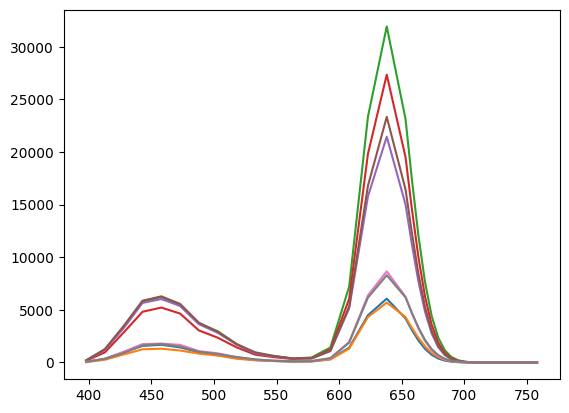

In [28]:
d = {
    'Peptide': [],
    'Trial': [],
    'Total': [],
    'LG-bit': [],
    'BRET': [],
    'Efficiency': [],
    'Medintz Ratio': []
}
for peptide in df['Peptide'].unique():
  for trial in df['Trial'].unique():
    print(peptide, trial)
    df_temp = df[(df['Peptide'] == peptide) & (df['Trial'] == trial)]
    #x, y = extrapolate(df_temp, 'Wavelength', 'Luminescence')
    x, y, popt = extrapolate_gaussian(df_temp, 'Wavelength (nm)', 'Luminescence (counts)', cutoff=563)
    sns.lineplot(x=x, y=y)
    all, lgbit, bret, efficiency = trapezoidal_int(x, y, 14)
    d['Peptide'].append(peptide)
    d['Trial'].append(trial)
    d['Total'].append(all)
    d['LG-bit'].append(lgbit)
    d['BRET'].append(bret)
    d['Efficiency'].append(efficiency)
    d['Medintz Ratio'].append(bret/lgbit)

brets = pd.DataFrame(d)
brets

In [29]:
# find the means across trials
brets_mean = brets.groupby('Peptide').mean(numeric_only=True)
brets_mean

,Total,LG-bit,BRET,Efficiency,Medintz Ratio
Peptide,,,,,
HiBiT-His6,1.483106e+06,498753.75,9.368439e+05,0.631540,1.877655
HiBiT-Pro3-His6,3.845624e+05,120930.00,2.511749e+05,0.653879,2.097694
His6-HiBiT,5.263639e+05,145657.50,3.633552e+05,0.690370,2.496237
His6-Pro3-HiBiT,1.772676e+06,462075.00,1.250883e+06,0.705756,2.708761


In [26]:
df[df['Wavelength (nm)']==638].groupby('Peptide').mean(numeric_only=True)

,Wavelength (nm),Luminescence (counts)
Peptide,,
HiBiT-His6,638.0,22399.5
HiBiT-Pro3-His6,638.0,5878.0
His6-HiBiT,638.0,8473.5
His6-Pro3-HiBiT,638.0,29645.0
